# Forecasting Electric Bills: A Machine Learning Approach to Budgeting with Weather and Usage Data

### Problem Description

Electric bills can fluctuate significantly based on several factors, such as weather conditions, energy consumption patterns, and changes in pricing. Unexpected increases in bills can disrupt budgeting plans, leading to financial strain. This project seeks to develop a supervised learning model to forecast electric bills using detailed weather data and ComEd usage data. By identifying the variables that influence energy consumption and bill amounts, the model will enable better budgeting and financial planning. This predictive tool could help users anticipate high bills and adjust their energy usage or budget accordingly.

For this analysis, I'm using my own Comed usage data for the last ~22 months.  I've downloaded the weather data for this period as well from open meteo.

# Step 1: Import Packages

In [79]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress all warnings
warnings.filterwarnings("ignore")


# Step 2: Import and Clean Usage Data

In [2]:
# Define file paths for usage data
usage_22_23 = 'data/comed/comed_usage_01.csv'
usage_23_24 = 'data/comed/comed_usage_02.csv'
usage_current = 'data/comed/comed_usage_03.csv'

# Load usage data from CSV files
usage_df1 = pd.read_csv(usage_22_23)
usage_df2 = pd.read_csv(usage_23_24)
usage_df3 = pd.read_csv(usage_current)

# Combine usage data into one DataFrame
usage_df = pd.concat([usage_df1, usage_df2, usage_df3], ignore_index=True)

# Clean usage data
usage_df.drop(columns=['TYPE', 'NOTES'], inplace=True)  # Drop unnecessary columns
usage_df.drop_duplicates(inplace=True)  # Remove duplicate rows
usage_df.reset_index(drop=True, inplace=True)  # Reset index

# Convert 'COST' to numeric type for analysis
usage_df['COST'] = usage_df['COST'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'DATE' column to datetime
usage_df['DATE'] = pd.to_datetime(usage_df['DATE'])

# Create 'datetime' column by combining 'DATE' and 'START TIME'
# This directly parses 'DATE' + 'START TIME' into a single datetime object
usage_df['datetime'] = pd.to_datetime(usage_df['DATE'].dt.strftime('%Y-%m-%d') + ' ' + usage_df['START TIME'])

# Aggregate usage data by hourly intervals
usage_hourly = usage_df.resample('H', on='datetime').agg({
    'USAGE (kWh)': 'sum',   # Sum usage for each hour
    'COST': 'sum'           # Sum cost for each hour
}).reset_index()

# Preview aggregated hourly usage data
usage_hourly.head()


,datetime,USAGE (kWh),COST
0,2022-12-31 23:00:00,0.32,0.05
1,2023-01-01 00:00:00,0.65,0.10
2,2023-01-01 01:00:00,0.65,0.09
3,2023-01-01 02:00:00,0.64,0.08
4,2023-01-01 03:00:00,0.57,0.10


#  Step 3: Import and Clean Bill Totals

In [3]:
# Load bill totals data
bill_totals_path = 'data/comed/bill_totals.csv'
bill_totals_df = pd.read_csv(bill_totals_path)

# Clean bill totals data
bill_totals_df.drop(columns=['TYPE', 'NOTES'], inplace=True)
bill_totals_df['START DATE'] = pd.to_datetime(bill_totals_df['START DATE'])
bill_totals_df['END DATE'] = pd.to_datetime(bill_totals_df['END DATE'])
bill_totals_df['COST'] = bill_totals_df['COST'].replace('[\$,]', '', regex=True).astype(float)
bill_totals_df['month_year'] = bill_totals_df['START DATE'].dt.to_period('M')

# Preview cleaned bill totals data
bill_totals_df.head()


,START DATE,END DATE,USAGE (kWh),COST,month_year
0,2022-08-31,2022-09-20,680.0,98.82,2022-08
1,2022-09-21,2022-10-19,403.0,58.26,2022-09
2,2022-10-20,2022-11-17,339.0,51.22,2022-10
3,2022-11-18,2022-12-20,619.0,92.74,2022-11
4,2022-12-21,2023-01-23,682.0,101.82,2022-12


# Step 4: Import and Clean Weather Data

In [4]:
# Load weather data
weather_path = 'data/weather/open-meteo-08312022-1142024.csv'
weather_df = pd.read_csv(weather_path)

# Clean and process weather data
weather_df['time'] = weather_df['time'].str.strip()
weather_df['datetime'] = pd.to_datetime(weather_df['time'], errors='coerce')
weather_df.drop(columns=['time'], inplace=True)

# Rename columns for clarity
weather_df.rename(columns={
    'temperature_2m (°F)': 'temperature',
    'relative_humidity_2m (%)': 'humidity',
    'dew_point_2m (°F)': 'dew_point',
    'apparent_temperature (°F)': 'apparent_temp',
    'precipitation (inch)': 'precipitation',
    'rain (inch)': 'rain',
    'snowfall (inch)': 'snowfall',
    'snow_depth (ft)': 'snow_depth',
    'weather_code (wmo code)': 'weather_code',
    'cloud_cover (%)': 'cloud_cover'
}, inplace=True)

# Preview cleaned weather data
weather_df.head()


,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,datetime
0,63.7,68,53.1,62.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 00:00:00
1,62.6,70,52.6,61.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 01:00:00
2,61.7,71,52.4,60.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 02:00:00
3,61.0,72,52.1,59.1,0.0,0.0,0.0,0.0,0,0,2022-08-31 03:00:00
4,60.7,72,51.7,58.3,0.0,0.0,0.0,0.0,0,0,2022-08-31 04:00:00


# Step 5: Merge Usage Data with Weather Data

In [5]:
# Merge usage data with weather data on 'datetime'
usage_weather_df = pd.merge(usage_hourly, weather_df, on='datetime', how='left')

# Add a 'month_year' column for later merging with bill totals
usage_weather_df['month_year'] = usage_weather_df['datetime'].dt.to_period('M')

# Preview the merged usage-weather data
usage_weather_df.head()




,datetime,USAGE (kWh),COST,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,month_year
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,0.0,3,100,2022-12
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,0.0,3,100,2023-01
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,0.0,3,100,2023-01
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,0.0,71,100,2023-01
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,0.0,61,100,2023-01


# Step 6: Merge Usage-Weather Data with Bill Totals

In [6]:
# Merge usage-weather data with bill totals on 'month_year'
final_data = pd.merge(
    usage_weather_df,
    bill_totals_df[['month_year', 'COST']],  # Only include relevant columns from bill totals
    on='month_year',
    how='left'
)

# Preview the final merged data
final_data.head()



,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,month_year,COST_y
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,0.0,3,100,2022-12,101.82
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,0.0,3,100,2023-01,89.92
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,0.0,3,100,2023-01,89.92
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,0.0,71,100,2023-01,89.92
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,0.0,61,100,2023-01,89.92


In [20]:
final_data.shape

(16393, 26)

In [21]:
# Filter the final_data to remove the months where I haven't received an actual bill total for the period
final_data_filtered = final_data.dropna(subset=['COST_y'])

In [23]:
final_data_filtered.shape

(15337, 26)

# Step 7: Account for Tesla Home Charging
Starting January 7, 2024, a Tesla was introduced, which significantly increased electricity usage due to regular home charging. 
This change introduces a structural break in the data, meaning patterns before and after this date are likely different. 
To address this, we:
1. Add a binary flag (`tesla_flag`) to indicate whether a record is before or after the Tesla's introduction.
2. Estimate and subtract Tesla's electricity usage from the total (`adjusted_usage`) to focus on household energy consumption.

These adjustments allow the model to account for the Tesla's impact and maintain meaningful predictions.


In [31]:
import pandas as pd

# Example Tesla monthly kWh usage
tesla_monthly_kwh = {
    '2024-01': 250,
    '2024-02': 267,
    '2024-03': 267,
    '2024-04': 254,
    '2024-05': 230,
    '2024-06': 209,
    '2024-07': 175,
    '2024-08': 304,
    '2024-09': 200
}

# Add a binary flag to indicate Tesla charging period
final_data_filtered.loc[:, 'tesla_flag'] = (final_data_filtered['datetime'] >= '2024-01-07').astype(int)

# Ensure month_year column is formatted consistently with Tesla monthly kWh keys
final_data_filtered.loc[:, 'month_year'] = final_data_filtered['datetime'].dt.to_period('M').astype(str)

# Convert tesla_monthly_kwh keys to Period objects for consistency
tesla_monthly_kwh_period = {pd.Period(key, freq='M'): value for key, value in tesla_monthly_kwh.items()}

# Map Tesla monthly kWh totals to each row
final_data_filtered.loc[:, 'tesla_kwh'] = final_data_filtered['datetime'].dt.to_period('M').map(tesla_monthly_kwh_period).fillna(0)

# Calculate the number of hours in each month
hours_in_month = final_data_filtered['datetime'].dt.days_in_month * 24

# Adjust usage by subtracting Tesla contribution
final_data_filtered.loc[:, 'adjusted_usage'] = final_data_filtered['USAGE (kWh)'] - (final_data_filtered['tesla_kwh'] / hours_in_month)

# Export the filtered DataFrame to Excel
final_data_filtered.to_excel('final_data_filtered.xlsx', sheet_name='Filtered Data', index=False)

# Preview the first few rows
final_data_filtered.head()


,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,...,tesla_kwh,adjusted_usage,snow_depth_inches,temperature_c,dew_point_c,temperature_range,heating_degree_days,cooling_degree_days,outlier_flag,day_of_week
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,...,0.0,0.32,0.0,1.555556,-0.555556,0.0,19.544444,0.0,0,Saturday
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,...,0.0,0.65,0.0,2.222222,0.444444,14.5,18.877778,0.0,0,Sunday
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,...,0.0,0.65,0.0,2.444444,1.000000,14.5,18.655556,0.0,0,Sunday
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,...,0.0,0.64,0.0,2.333333,1.444444,14.5,18.766667,0.0,0,Sunday
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,...,0.0,0.57,0.0,2.388889,1.611111,14.5,18.711111,0.0,0,Sunday


# Compare Usage Pre- and Post-Tesla

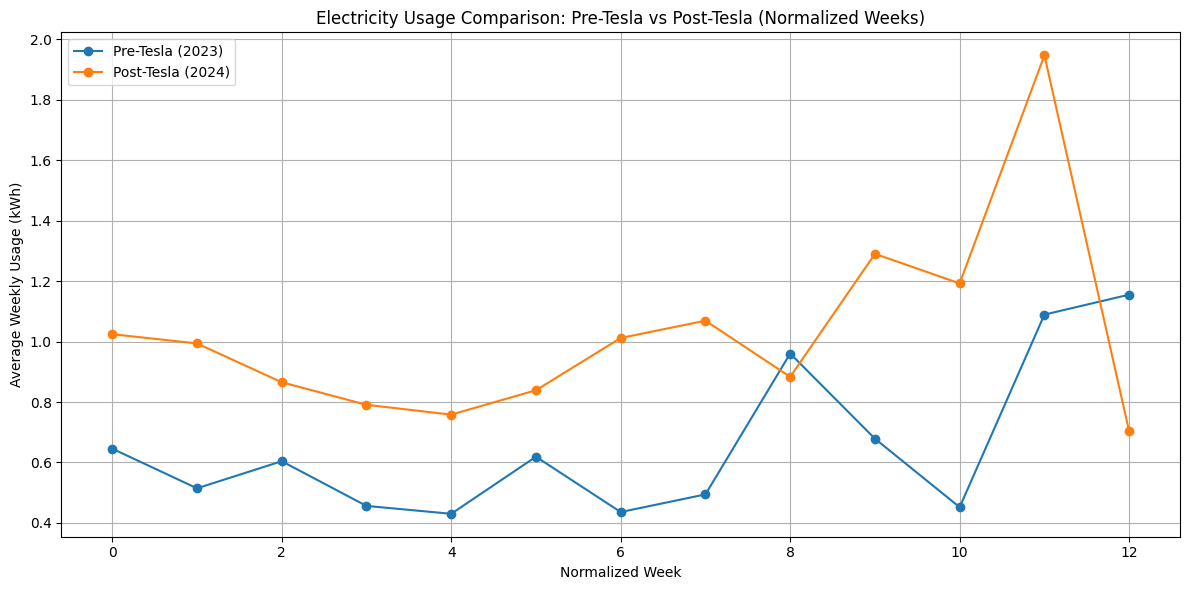

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the period for comparison (April 1 to July 1 for each year)
start_period_pre_tesla = '2023-04-01'
end_period_pre_tesla = '2023-07-01'
start_period_post_tesla = '2024-04-01'
end_period_post_tesla = '2024-07-01'

# Filter data for the pre-Tesla period
pre_tesla_data = final_data_filtered[
    (final_data_filtered['datetime'] >= start_period_pre_tesla) &
    (final_data_filtered['datetime'] < end_period_pre_tesla)
].copy()

# Filter data for the post-Tesla period
post_tesla_data = final_data_filtered[
    (final_data_filtered['datetime'] >= start_period_post_tesla) &
    (final_data_filtered['datetime'] < end_period_post_tesla)
].copy()

# Normalize dates to start at the same point for both periods
pre_tesla_data.loc[:, 'normalized_week'] = (pre_tesla_data['datetime'] - pd.to_datetime(start_period_pre_tesla)).dt.days // 7
post_tesla_data.loc[:, 'normalized_week'] = (post_tesla_data['datetime'] - pd.to_datetime(start_period_post_tesla)).dt.days // 7

# Summarize data by normalized week
pre_tesla_weekly = pre_tesla_data.groupby('normalized_week')['USAGE (kWh)'].mean().reset_index()
post_tesla_weekly = post_tesla_data.groupby('normalized_week')['USAGE (kWh)'].mean().reset_index()

# Plot the summarized weekly data
plt.figure(figsize=(12, 6))

# Plot pre-Tesla data
plt.plot(pre_tesla_weekly['normalized_week'], pre_tesla_weekly['USAGE (kWh)'], marker='o', linestyle='-', label='Pre-Tesla (2023)')

# Plot post-Tesla data
plt.plot(post_tesla_weekly['normalized_week'], post_tesla_weekly['USAGE (kWh)'], marker='o', linestyle='-', label='Post-Tesla (2024)')

# Customize the plot
plt.title('Electricity Usage Comparison: Pre-Tesla vs Post-Tesla (Normalized Weeks)')
plt.xlabel('Normalized Week')
plt.ylabel('Average Weekly Usage (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


The visualization indicates that the post-Tesla average weekly electricity usage is consistently higher across the 12-week period compared to the pre-Tesla period.  This observation highlights the importance of incorporating the adjusted usage metric, as it accounts for the Tesla's charging consumption and provides a clearer picture of baseline electricity usage trends.

# Step 8: Data Cleaning

In [43]:
# Need to convert the snow depth from feet to inches so as to align with snow fall
final_data_filtered.loc[:,'snow_depth_inches'] =  final_data_filtered['snow_depth'] * 12

In [47]:
from scipy.stats import zscore

# Step 1: Handle missing values
# Fill missing values for snow_depth (assumed missing = 0)
final_data_filtered.loc[:, 'snow_depth'] = final_data_filtered['snow_depth'].fillna(0)

# Fill missing values for weather variables with their respective means
weather_columns = ['temperature', 'humidity', 'dew_point', 'precipitation', 
                   'rain', 'snowfall', 'snow_depth_inches', 'cloud_cover']
for col in weather_columns:
    final_data_filtered.loc[:, col] = final_data_filtered[col].fillna(final_data_filtered[col].mean())

# Step 2: Standardize units and formats
# Convert temperature from Fahrenheit to Celsius (C = (F - 32) * 5/9)
final_data_filtered.loc[:, 'temperature_c'] = (final_data_filtered['temperature'] - 32) * 5/9
final_data_filtered.loc[:, 'dew_point_c'] = (final_data_filtered['dew_point'] - 32) * 5/9

# Step 3: Create new features
# Create a temperature range feature (difference between max and min temperature in a day)
final_data_filtered.loc[:, 'temperature_range'] = final_data_filtered.groupby(
    final_data_filtered['datetime'].dt.date
)['temperature'].transform(lambda x: x.max() - x.min())

# Create degree days feature
# Degree days measure heating or cooling demand based on deviations from baseline temperatures.
# HDD (Heating Degree Days): Measures how much the temperature is below a heating baseline.
# CDD (Cooling Degree Days): Measures how much the temperature is above a cooling baseline.

# Adjusted baselines for heating and cooling
heating_baseline_c = 21.1  # 70°F in Celsius
cooling_baseline_c = 22.2  # 72°F in Celsius

# Adjusted Heating Degree Days (HDD)
final_data_filtered.loc[:, 'heating_degree_days'] = final_data_filtered['temperature_c'].apply(
    lambda x: max(heating_baseline_c - x, 0)
)

# Adjusted Cooling Degree Days (CDD)
final_data_filtered.loc[:, 'cooling_degree_days'] = final_data_filtered['temperature_c'].apply(
    lambda x: max(x - cooling_baseline_c, 0)
)

# HDD and CDD are useful for understanding how temperature extremes influence energy consumption.

# Step 4: Remove or flag outliers
# Define columns to check for outliers
outlier_columns = ['USAGE (kWh)', 'temperature', 'precipitation', 'snowfall']

# Calculate z-scores for each column
for col in outlier_columns:
    final_data_filtered.loc[:, f'zscore_{col}'] = zscore(final_data_filtered[col])

# Flag outliers (absolute z-score > 3)
final_data_filtered.loc[:, 'outlier_flag'] = (
    (final_data_filtered['zscore_USAGE (kWh)'].abs() > 3) |
    (final_data_filtered['zscore_temperature'].abs() > 3) |
    (final_data_filtered['zscore_precipitation'].abs() > 3) |
    (final_data_filtered['zscore_snowfall'].abs() > 3)
).astype(int)

# Drop unnecessary z-score columns after flagging outliers
zscore_columns = [f'zscore_{col}' for col in outlier_columns]
final_data_filtered.drop(columns=zscore_columns, inplace=True)

# Preview the updated dataset
final_data_filtered.head()


,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,...,tesla_kwh,adjusted_usage,snow_depth_inches,temperature_c,dew_point_c,temperature_range,heating_degree_days,cooling_degree_days,outlier_flag,day_of_week
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,...,0.0,0.32,0.0,1.555556,-0.555556,0.0,19.544444,0.0,0,Saturday
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,...,0.0,0.65,0.0,2.222222,0.444444,14.5,18.877778,0.0,0,Sunday
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,...,0.0,0.65,0.0,2.444444,1.000000,14.5,18.655556,0.0,0,Sunday
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,...,0.0,0.64,0.0,2.333333,1.444444,14.5,18.766667,0.0,0,Sunday
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,...,0.0,0.57,0.0,2.388889,1.611111,14.5,18.711111,0.0,0,Sunday


# Step 8: Analyze Trends in Electricity Usage Over Time
In this step, we explore trends in electricity usage across different time scales, such as daily, weekly, and seasonal trends. 
This helps identify patterns that may influence energy consumption, such as increased usage on weekdays or during specific seasons.


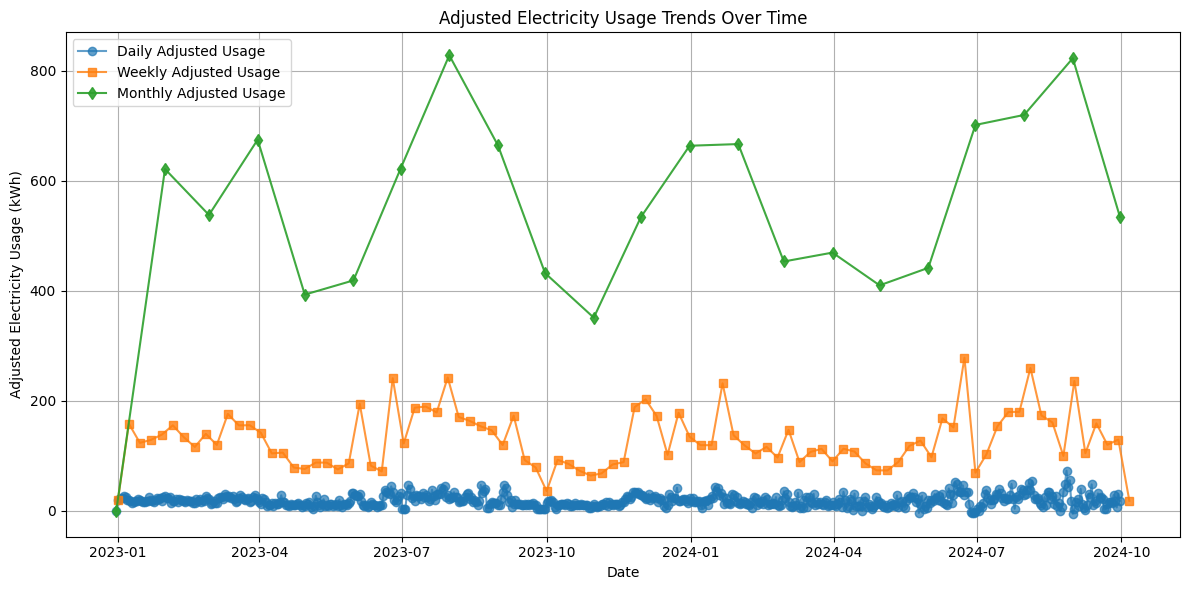

In [48]:
import matplotlib.pyplot as plt

# Ensure 'datetime' is in datetime format
final_data_filtered['datetime'] = pd.to_datetime(final_data_filtered['datetime'])

# Resample data to daily, weekly, and monthly averages using adjusted_usage
daily_adjusted_usage = final_data_filtered.resample('D', on='datetime')['adjusted_usage'].sum()
weekly_adjusted_usage = final_data_filtered.resample('W', on='datetime')['adjusted_usage'].sum()
monthly_adjusted_usage = final_data_filtered.resample('M', on='datetime')['adjusted_usage'].sum()

# Plot daily, weekly, and monthly trends for adjusted usage
plt.figure(figsize=(12, 6))
plt.plot(daily_adjusted_usage, label='Daily Adjusted Usage', linestyle='-', marker='o', alpha=0.7)
plt.plot(weekly_adjusted_usage, label='Weekly Adjusted Usage', linestyle='-', marker='s', alpha=0.8)
plt.plot(monthly_adjusted_usage, label='Monthly Adjusted Usage', linestyle='-', marker='d', alpha=0.9)

# Customize the plot
plt.title('Adjusted Electricity Usage Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Electricity Usage (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


Findings:
The daily adjusted usage trend is noisy, making it difficult to extract meaningful insights. The weekly trend, however, reveals a seasonal pattern, with increased electricity usage during the colder winter months and warmer summer months, along with a noticeable dip during the spring. This seasonality becomes clearer in the monthly trend.

Possible Explanation:
In my household, we primarily use gas for heating, but our furnace's electric components (e.g., blower motor and ignition system) may account for increased electricity usage during winter, as it operates more frequently in colder weather. Additionally, shorter daylight hours lead to greater reliance on lighting, and increased indoor activity during the winter months may contribute to higher appliance and electronics usage. These factors likely explain the observed winter electricity spike, even without heavy use of space heaters.

# Step 9: Visualize Correlations Between Electricity Usage and Weather Variables
Here, we examine correlations between electricity usage and weather factors such as temperature, humidity, and rainfall. 
Visualizing these relationships helps identify which weather conditions have the most significant impact on energy consumption.


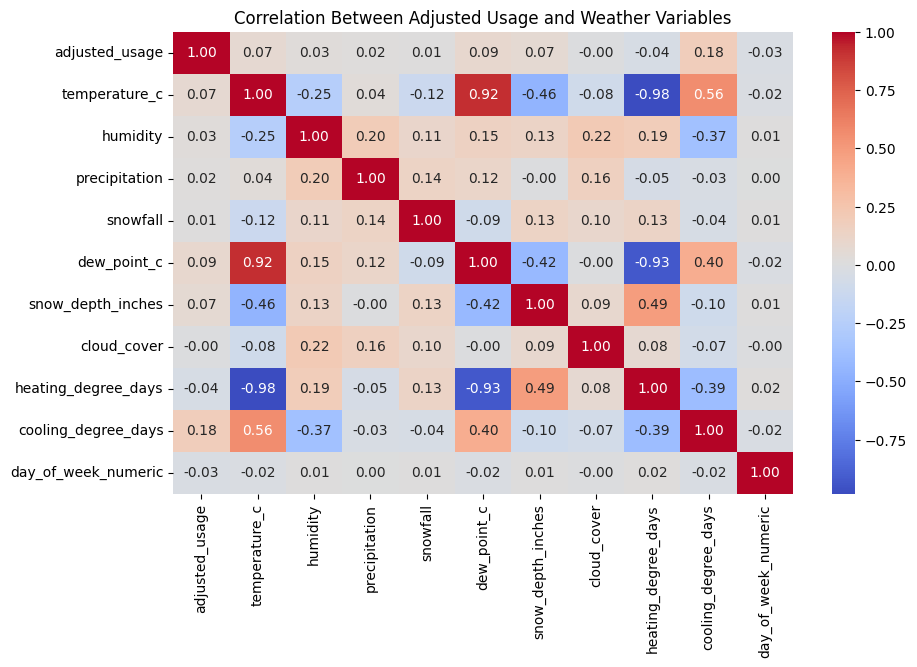

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map days of the week to numeric values
day_of_week_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
final_data_filtered['day_of_week_numeric'] = final_data_filtered['day_of_week'].map(day_of_week_mapping)

# Select variables for the correlation matrix
correlation_data_adjusted = final_data_filtered[[
    'adjusted_usage', 'temperature_c', 'humidity', 'precipitation',
    'snowfall', 'dew_point_c', 'snow_depth_inches', 'cloud_cover',
    'heating_degree_days', 'cooling_degree_days', 'day_of_week_numeric'
]]

# Compute the correlation matrix
correlation_matrix_adjusted = correlation_data_adjusted.corr()

# Plot adjusted correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_adjusted, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Adjusted Usage and Weather Variables')
plt.show()


The correlation matrix reveals that none of the variables have a particularly strong correlation with adjusted electricity usage. However, temperature_c, dew_point_c, and cooling_degree_days exhibit the highest correlations, suggesting that these weather-related factors have a noticeable influence on electricity consumption. This aligns with expectations, as temperature extremes likely drive the usage of cooling systems, impacting energy consumption.

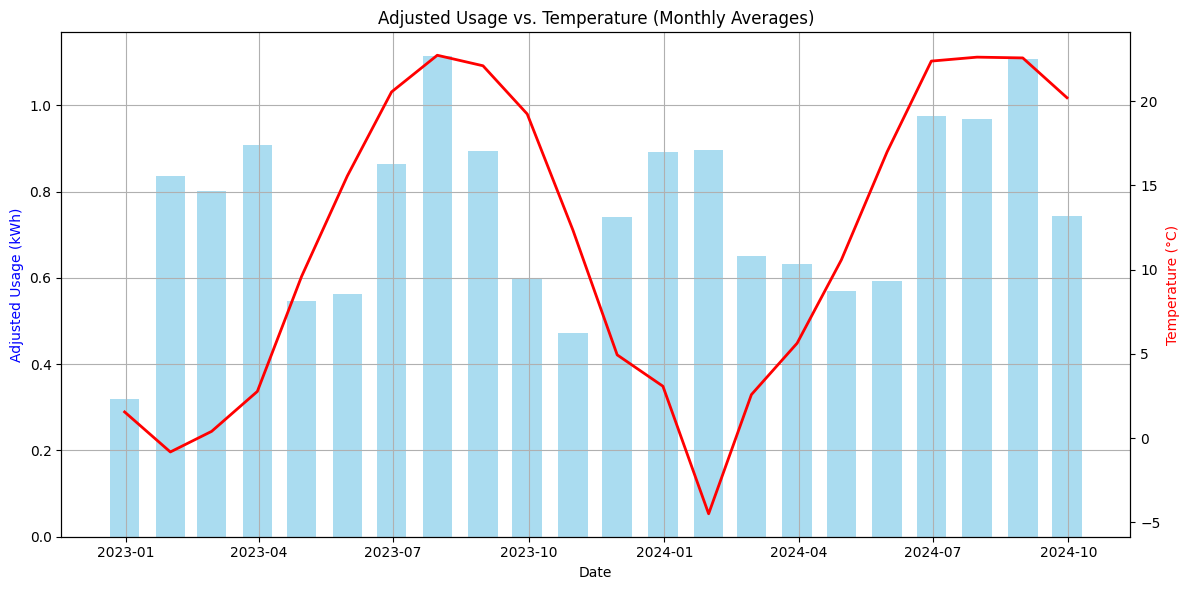

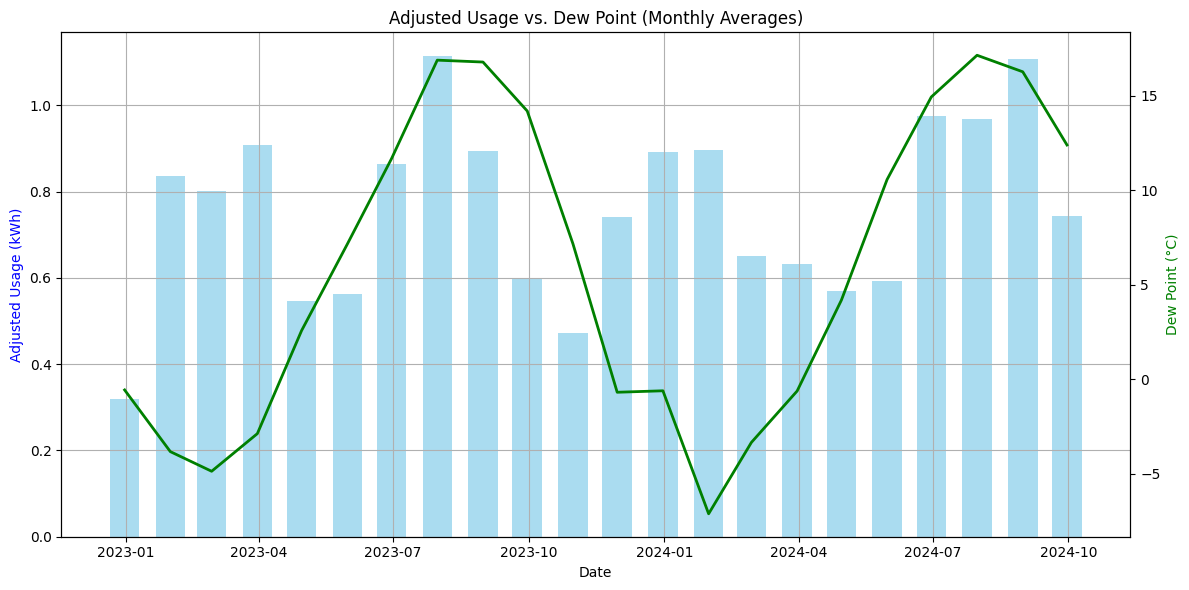

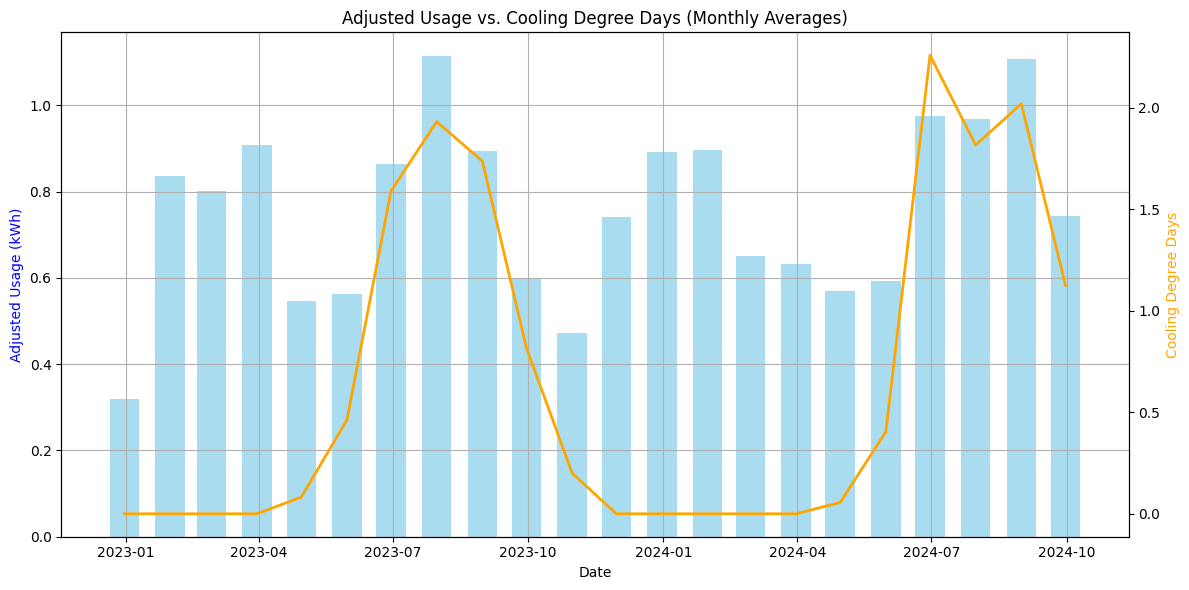

In [58]:
import matplotlib.pyplot as plt

# Plot 1: Adjusted Usage vs. Temperature
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

bar_width = 20  # Adjust bar width for thicker bars
ax1.bar(monthly_data.index, monthly_data['adjusted_usage'], color='skyblue', alpha=0.7, label='Adjusted Usage (kWh)', width=bar_width)
ax2.plot(monthly_data.index, monthly_data['temperature_c'], color='red', linewidth=2, label='Temperature (°C)')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Usage (kWh)', color='blue')
ax2.set_ylabel('Temperature (°C)', color='red')
plt.title('Adjusted Usage vs. Temperature (Monthly Averages)')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()
plt.show()

# Plot 2: Adjusted Usage vs. Dew Point
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.bar(monthly_data.index, monthly_data['adjusted_usage'], color='skyblue', alpha=0.7, label='Adjusted Usage (kWh)', width=bar_width)
ax2.plot(monthly_data.index, monthly_data['dew_point_c'], color='green', linewidth=2, label='Dew Point (°C)')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Usage (kWh)', color='blue')
ax2.set_ylabel('Dew Point (°C)', color='green')
plt.title('Adjusted Usage vs. Dew Point (Monthly Averages)')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()
plt.show()

# Plot 3: Adjusted Usage vs. Cooling Degree Days
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.bar(monthly_data.index, monthly_data['adjusted_usage'], color='skyblue', alpha=0.7, label='Adjusted Usage (kWh)', width=bar_width)
ax2.plot(monthly_data.index, monthly_data['cooling_degree_days'], color='orange', linewidth=2, label='Cooling Degree Days')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Usage (kWh)', color='blue')
ax2.set_ylabel('Cooling Degree Days', color='orange')
plt.title('Adjusted Usage vs. Cooling Degree Days (Monthly Averages)')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()
plt.show()


The visuals reveal that these variables align well with electricity usage during the warmer summer months, highlighting their positive correlation. However, in the winter months, we observe an inverse relationship where these variables decline, yet electricity usage increases. This discrepancy could be attributed to factors such as shorter daylight hours and increased indoor activity during the winter, as previously mentioned. To better understand and capture these patterns, we will create additional features, such as daylight duration as well as seasonality, to account for these seasonal dynamics.

In [60]:
# Example daylight hours feature (replace with actual sunrise/sunset data if available)
final_data_filtered['daylight_hours'] = final_data_filtered['datetime'].dt.dayofyear.apply(
    lambda x: max(0, 12 - abs(x - 172) / 15)  # Approximation: longest day is DOY 172 (June 21)
)


# Create a season feature
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

final_data_filtered['season'] = final_data_filtered['datetime'].dt.month.apply(assign_season)


In [65]:
final_data_filtered.head()

,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,...,temperature_c,dew_point_c,temperature_range,heating_degree_days,cooling_degree_days,outlier_flag,day_of_week,day_of_week_numeric,daylight_hours,season
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,...,1.555556,-0.555556,0.0,19.544444,0.0,0,Saturday,5,0.0,Winter
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,...,2.222222,0.444444,14.5,18.877778,0.0,0,Sunday,6,0.6,Winter
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,...,2.444444,1.000000,14.5,18.655556,0.0,0,Sunday,6,0.6,Winter
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,...,2.333333,1.444444,14.5,18.766667,0.0,0,Sunday,6,0.6,Winter
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,...,2.388889,1.611111,14.5,18.711111,0.0,0,Sunday,6,0.6,Winter


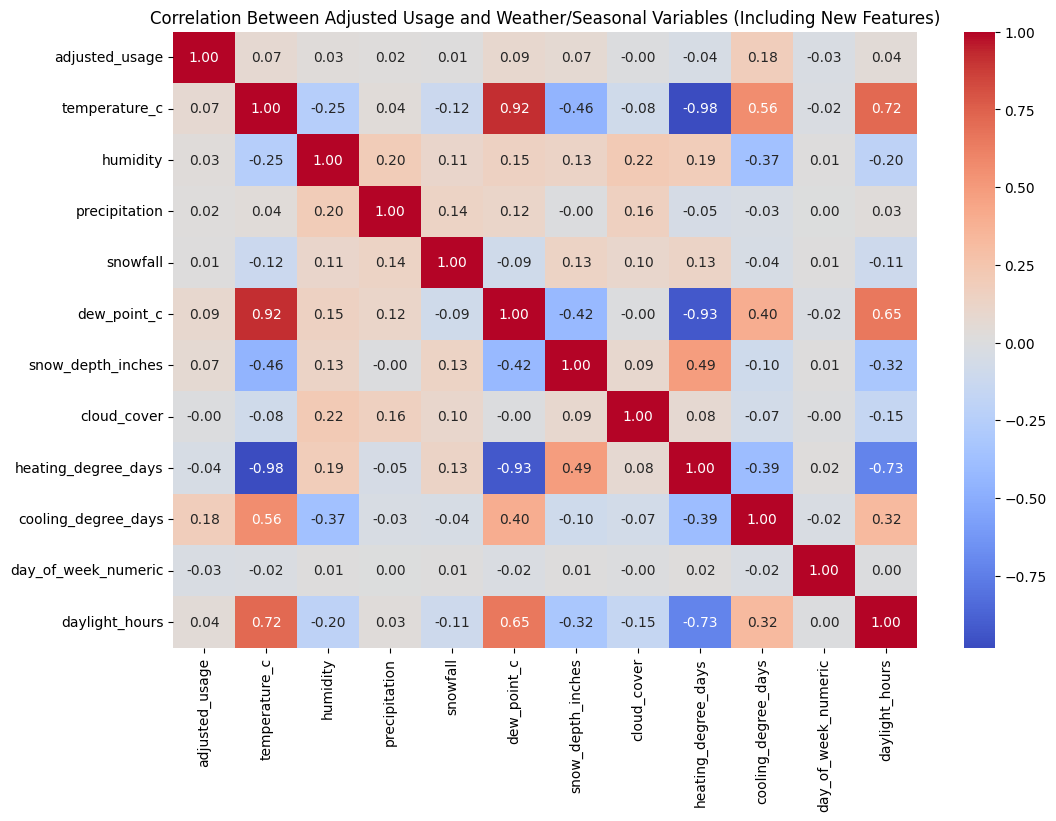

In [63]:
# Assuming 'daylight_hours' and any other newly created features are already added to final_data_filtered

# Update the correlation matrix to include new features
correlation_data_with_new_features = final_data_filtered[[
    'adjusted_usage', 'temperature_c', 'humidity', 'precipitation', 'snowfall', 
    'dew_point_c', 'snow_depth_inches', 'cloud_cover', 'heating_degree_days', 
    'cooling_degree_days', 'day_of_week_numeric', 'daylight_hours'
]]

# Calculate the correlation matrix
correlation_matrix_with_new_features = correlation_data_with_new_features.corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_with_new_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Adjusted Usage and Weather/Seasonal Variables (Including New Features)')
plt.show()


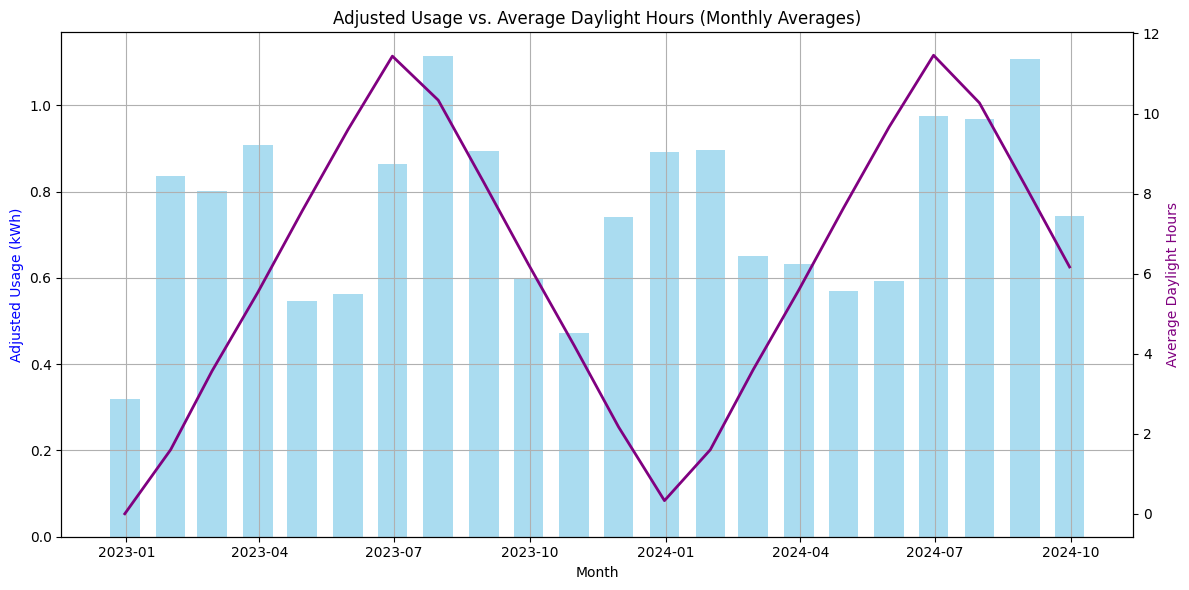

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'datetime' is in datetime format
final_data_filtered['datetime'] = pd.to_datetime(final_data_filtered['datetime'])

# Select only numeric columns for aggregation
numeric_columns = final_data_filtered.select_dtypes(include=['float64', 'int64']).columns
monthly_data = final_data_filtered.resample('M', on='datetime')[numeric_columns].mean()

# Plot Adjusted Usage vs. Daylight Hours (Monthly Averages)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar and Line Chart for Adjusted Usage and Daylight Hours
bar_width = 20  # Adjust bar width for thicker bars
ax1.bar(monthly_data.index, monthly_data['adjusted_usage'], color='skyblue', alpha=0.7, label='Adjusted Usage (kWh)', width=20)
ax2.plot(monthly_data.index, monthly_data['daylight_hours'], color='purple', linewidth=2, label='Average Daylight Hours')

# Axis Labels and Title
ax1.set_xlabel('Month')
ax1.set_ylabel('Adjusted Usage (kWh)', color='blue')
ax2.set_ylabel('Average Daylight Hours', color='purple')
plt.title('Adjusted Usage vs. Average Daylight Hours (Monthly Averages)')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()
plt.show()


Including the daylight_hours feature in the correlation matrix reveals a modest correlation of 0.04 with adjusted electricity usage. While relatively weak, this correlation suggests that daylight duration may have a minor influence on electricity consumption patterns. The trend of adjusted usage and average daylight hours supports the hypothesis that shorter daylight hours in winter could contribute to increased indoor activity and lighting usage. In particular, during the winter and early spring months, the reduced daylight aligns with increased electricity usage, likely driven by greater reliance on artificial lighting and more time spent indoors.

# Summary of Findings and Next Steps

Our analysis so far has shown that no single variable has a strong correlation with adjusted electricity usage or cost. That said, variables like temperature_c, dew_point_c, and cooling_degree_days show some relationship with usage, and daylight_hours provides useful context, especially for understanding seasonal trends. For example, we’ve seen that usage tends to increase during the winter months when daylight hours are shorter, which makes sense given the need for more lighting and indoor activity during that time. Overall, it’s clear that electricity usage is influenced by a combination of factors rather than any one variable on its own.

To dig deeper, we’ll start modeling the data using Gradient Boosting. This model is a good choice because it can handle complex, nonlinear relationships and interactions between features without needing to define those interactions manually. It’s also great for identifying which features are most important to the predictions and has built-in tools to avoid overfitting. By starting with Gradient Boosting, we can get a better sense of how the different factors we’ve explored come together to predict usage and cost.

One key consideration when building machine learning models is whether multicollinearity or interactions between features may impact model performance. Tree-based models like Gradient Boosting are inherently robust to multicollinearity because they split features independently. Additionally, Gradient Boosting can capture feature interactions automatically during the training process. For this reason, we do not need to explicitly address these issues when using Gradient Boosting, unlike in models like linear regression. Instead, we focus on including meaningful features and allow the model to determine their importance and interaction effects.

## Split the Data into Training and Testing Sets

In [72]:
# Define features (X) and target (y)
X = final_data_filtered[['temperature_c', 'dew_point_c', 'cooling_degree_days', 'heating_degree_days', 'daylight_hours']]
y = final_data_filtered['adjusted_usage']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (12269, 5)
Testing set size: (3068, 5)


For our initial Gradient Boosting model, we’ve selected the following features:

temperature_c
dew_point_c
cooling_degree_days
heating_degree_days
daylight_hours
These features were chosen based on their relevance to electricity usage patterns, as observed during the exploratory data analysis:

Weather Variables (temperature_c, dew_point_c, cooling_degree_days, and heating_degree_days):

These features have shown modest correlations with adjusted electricity usage in our analysis. For instance, cooling_degree_days aligns with higher usage in summer months due to air conditioning demands, while heating_degree_days helps account for usage during colder periods.
Even though individual correlations may not be strong, these variables likely interact with each other to influence electricity usage.
Daylight Hours:

While daylight_hours had a weak direct correlation with adjusted usage, it provides important context for seasonal trends. Shorter daylight periods in winter likely contribute to increased lighting and indoor activity, impacting electricity usage indirectly.
We avoided including all features in the dataset at this stage to:

Reduce noise and focus on variables with potential predictive power.
Minimize computational complexity during initial modeling.
Prioritize features that align with domain knowledge and the insights from our exploratory data analysis.
As we progress, we may revisit this feature set, adding or removing variables based on their contribution to the model's performance, as indicated by feature importance scores or evaluation metrics. Starting with a focused subset of features allows us to build a strong baseline model before experimenting with additional data.


## Train the Gradient Boosting Model

We use GradientBoostingRegressor to train the model. We'll start with default hyperparameters and later optimize them to improve performance.

In [73]:
# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Print feature importances
feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)


Feature Importances:
dew_point_c            0.455391
daylight_hours         0.388511
temperature_c          0.065839
heating_degree_days    0.048227
cooling_degree_days    0.042032
dtype: float64


The model identified dew_point_c (45.5%) and daylight_hours (38.9%) as the most important predictors, highlighting the influence of humidity and seasonal lighting patterns on electricity usage. In contrast, temperature_c, heating_degree_days, and cooling_degree_days had much lower contributions, suggesting that other unmeasured factors or interactions may play a larger role in electricity consumption.

## Evaluate the Model

In [74]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 0.44
Mean Absolute Error (MAE): 0.50
R² Score: 0.17


The Gradient Boosting model achieved an MSE of 0.44, an MAE of 0.50, and an R² score of 0.17. While the model captures some patterns, the low R² suggests that most of the variability in electricity usage remains unexplained. These results indicate room for improvement through feature engineering, hyperparameter tuning, or exploring alternative models.

## Optimize Hyperparameters

To improve performance, we use GridSearchCV to find the best combination of hyperparameters for the Gradient Boosting model.

In [75]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='r2', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Squared Error (MSE): {mse_best:.2f}")
print(f"Optimized Mean Absolute Error (MAE): {mae_best:.2f}")
print(f"Optimized R² Score: {r2_best:.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Optimized Mean Squared Error (MSE): 0.41
Optimized Mean Absolute Error (MAE): 0.47
Optimized R² Score: 0.23


### Initial Model Performance Summary

The optimized Gradient Boosting model demonstrates moderate predictive performance based on the following metrics:

- **Best Hyperparameters**: The model achieved its best performance with a learning rate of 0.1, a maximum depth of 5, and 300 estimators. These hyperparameters suggest that the model benefits from a balance between capturing complexity (depth) and iterative learning (estimators).
  
- **Mean Squared Error (MSE)**: 0.41 indicates the average squared difference between the predicted and actual values. While relatively low, it highlights room for improvement, particularly in reducing large prediction errors.

- **Mean Absolute Error (MAE)**: 0.47 shows the average absolute difference between predictions and actual values, suggesting that on average, predictions deviate by approximately 0.47 units from the actual electricity usage.

- **R² Score**: 0.23 indicates that the model explains about 23% of the variance in the target variable. While this is a modest level of explanatory power, it confirms the presence of significant unexplained variance.

### Insights

This baseline performance is a good starting point, revealing that while the Gradient Boosting model captures some patterns in the data, there is substantial opportunity for improvement. Enhancing the feature set through feature engineering, exploring additional models, or tuning the hyperparameters further may yield better results.

### **Next Steps: Feature Engineering**

To improve the model’s performance, we will now proceed with feature engineering. This involves creating new features that may better capture the underlying relationships between the predictors and the target variable. Here’s the plan:

#### **1. Create Interaction Features**
Interaction features combine two or more variables to capture their combined effect on electricity usage, which may be stronger than their individual effects.
- **`temperature_c × humidity`**: To model how heat and humidity together influence electricity demand, especially for cooling needs.
- **`cloud_cover × daylight_hours`**: To account for how cloudiness reduces effective daylight, potentially impacting lighting usage.

#### **2. Introduce Lagged Features**
Lagged features help the model learn temporal patterns by incorporating past usage data.
- **`previous_day_usage`**: Includes electricity usage from the previous day, capturing short-term trends.
- **`previous_week_usage`**: Reflects the usage pattern from the same day in the previous week, capturing weekly cycles.

#### **3. Apply Non-Linear Transformations**
Some relationships might be non-linear, where the rate of change decreases or increases at certain thresholds.
- **`daylight_hours²`**: Explores whether the effect of daylight hours on usage diminishes or amplifies as daylight increases.

#### **4. Evaluate Feature Importance**
Once the new features are added, we will:
- Retrain the Gradient Boosting model.
- Reassess the model’s performance using evaluation metrics (MSE, MAE, R²).
- Recalculate feature importances to identify the most influential variables.


In [76]:
# Create interaction features
final_data_filtered['temp_humidity_interaction'] = final_data_filtered['temperature_c'] * final_data_filtered['humidity']
final_data_filtered['cloud_daylight_interaction'] = final_data_filtered['cloud_cover'] * final_data_filtered['daylight_hours']

# Create lagged features
final_data_filtered['previous_day_usage'] = final_data_filtered['adjusted_usage'].shift(1)
final_data_filtered['previous_week_usage'] = final_data_filtered['adjusted_usage'].shift(7)

# Create non-linear transformation
final_data_filtered['daylight_hours_squared'] = final_data_filtered['daylight_hours'] ** 2

# Drop rows with NaN values created by lagged features
final_data_filtered = final_data_filtered.dropna()

# Preview the updated dataset
final_data_filtered.head()


,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,...,outlier_flag,day_of_week,day_of_week_numeric,daylight_hours,season,temp_humidity_interaction,cloud_daylight_interaction,previous_day_usage,previous_week_usage,daylight_hours_squared
7,2023-01-01 06:00:00,0.68,0.09,35.1,99,34.8,29.2,0.0,0.0,0.0,...,0,Sunday,6,0.6,Winter,170.500000,39.0,0.61,0.32,0.36
8,2023-01-01 07:00:00,0.58,0.09,36.6,98,36.2,31.4,0.0,0.0,0.0,...,0,Sunday,6,0.6,Winter,250.444444,40.2,0.68,0.65,0.36
9,2023-01-01 08:00:00,0.61,0.09,35.2,99,35.0,29.3,0.0,0.0,0.0,...,0,Sunday,6,0.6,Winter,176.000000,60.0,0.58,0.65,0.36
10,2023-01-01 09:00:00,0.66,0.08,37.4,99,37.1,32.2,0.0,0.0,0.0,...,0,Sunday,6,0.6,Winter,297.000000,60.0,0.61,0.64,0.36
11,2023-01-01 10:00:00,0.53,0.08,39.9,94,38.3,35.0,0.0,0.0,0.0,...,0,Sunday,6,0.6,Winter,412.555556,60.0,0.66,0.57,0.36


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   4.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   3.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_es

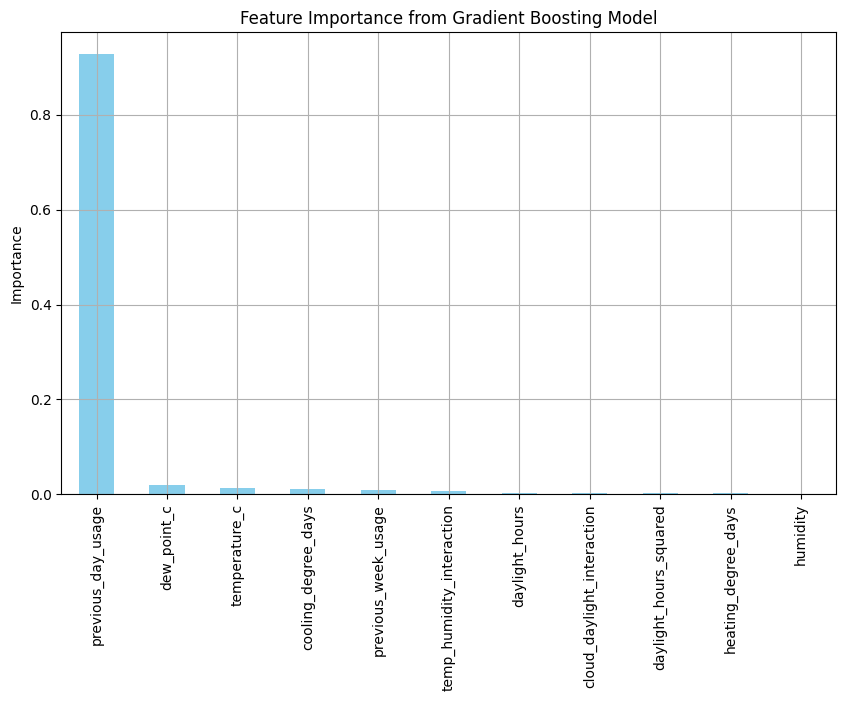

In [77]:
# Step 1: Prepare the dataset with engineered features
# Select features for X and target for y
features = [
    'temperature_c', 'humidity', 'dew_point_c', 'daylight_hours',
    'heating_degree_days', 'cooling_degree_days', 
    'temp_humidity_interaction', 'cloud_daylight_interaction',
    'previous_day_usage', 'previous_week_usage', 'daylight_hours_squared'
]
X = final_data_filtered[features]
y = final_data_filtered['adjusted_usage']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Step 4: Evaluate the optimized model
optimized_model = grid_search.best_estimator_

# Predict on test set
y_pred = optimized_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE): {mse:.2f}")
print(f"Optimized Mean Absolute Error (MAE): {mae:.2f}")
print(f"Optimized R² Score: {r2:.2f}")

# Step 5: Analyze feature importance
feature_importance = pd.Series(optimized_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance from Gradient Boosting Model')
plt.ylabel('Importance')
plt.grid(True)
plt.show()

### Model Performance After Feature Engineering

After incorporating the newly engineered features, the Gradient Boosting model's performance improved significantly. Using the optimized hyperparameters (`learning_rate = 0.05`, `max_depth = 3`, `n_estimators = 100`), the model achieved the following metrics:
- **Mean Squared Error (MSE):** 0.23
- **Mean Absolute Error (MAE):** 0.31
- **R² Score:** 0.55

The R² score now indicates that the model explains 55% of the variance in adjusted electricity usage, a substantial improvement from the initial model's R² of 0.23. The reduced MSE and MAE further validate that the model's predictions are more accurate after feature engineering.

### Feature Importances

The feature importance analysis reveals which variables contributed most to the model’s predictive performance:
1. **`previous_day_usage` (92.76%)**: This is overwhelmingly the most impactful feature, confirming that electricity consumption habits are strongly influenced by recent usage. This aligns with the expectation that energy usage tends to follow consistent patterns over short periods.
2. **Weather Variables**:
   - **`dew_point_c` (2.03%) and `temperature_c` (1.32%)**: While weather-related factors remain relevant, their importance diminishes significantly when accounting for behavioral patterns like previous day usage.
   - **`cooling_degree_days` (1.13%) and `heating_degree_days` (0.21%)**: These capture the impact of extreme weather conditions but are less predictive than expected, potentially due to other compensating behaviors or systems (e.g., gas heating).
3. **Engineered Features**:
   - **`previous_week_usage` (0.89%)**: Provides additional behavioral context over a longer timeframe.
   - **Interaction Terms**: Features like `temp_humidity_interaction` and `cloud_daylight_interaction` contributed small but meaningful amounts, adding nuance to the model's understanding of energy usage drivers.
4. **Daylight-Related Features** (`daylight_hours`, `daylight_hours_squared`, `cloud_daylight_interaction`): These had low importance, aligning with earlier observations of weak correlation with electricity usage. While not as impactful, including them ensures the model considers a comprehensive set of factors.

### Insights

The analysis highlights that behavioral patterns, particularly recent usage (`previous_day_usage`), are the dominant drivers of electricity consumption predictions. Environmental factors like weather play a secondary role, and daylight-related features have minimal impact. These findings underscore the value of behavior-based features for predicting energy usage.

To further validate these insights and explore alternative modeling approaches, I’ll now compare the Gradient Boosting model with Random Forest to ensure a robust evaluation.

We'll use the same dataset as the Gradient Boosting model with the same features and target variables.

# Preparing the Data

In [78]:
# Features and target
X = final_data_filtered[['previous_day_usage', 'previous_week_usage', 'dew_point_c', 
                         'temperature_c', 'cooling_degree_days', 'heating_degree_days', 
                         'temp_humidity_interaction', 'daylight_hours', 
                         'daylight_hours_squared', 'cloud_daylight_interaction', 'humidity']]
y = final_data_filtered['adjusted_usage']

# Splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Building the Random Forest Model

In [80]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best hyperparameters
best_rf = grid_search_rf.best_estimator_
print("Best Hyperparameters:", grid_search_rf.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


# Evaluating the Model

In [81]:
# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Random Forest Model Performance:
Mean Squared Error (MSE): 0.23
Mean Absolute Error (MAE): 0.30
R² Score: 0.55


# Analyzing Feature Importances

Feature Importances:
previous_day_usage            0.790422
previous_week_usage           0.038093
dew_point_c                   0.031483
temperature_c                 0.028154
temp_humidity_interaction     0.023480
cloud_daylight_interaction    0.022653
humidity                      0.018322
cooling_degree_days           0.016557
daylight_hours                0.013112
daylight_hours_squared        0.012496
heating_degree_days           0.005228
dtype: float64


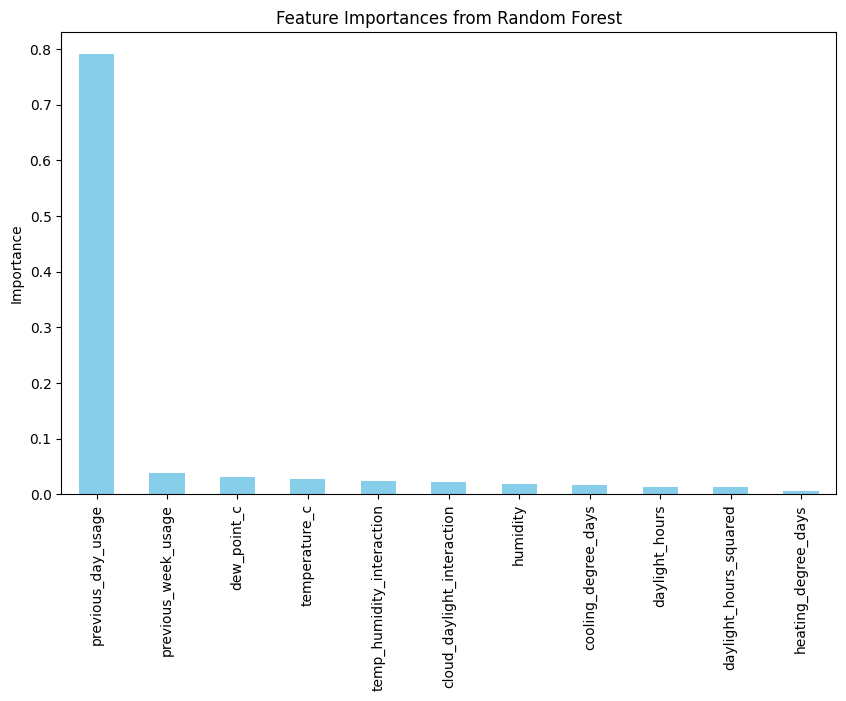

In [83]:
# Feature importances
feature_importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances_rf)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importances_rf.plot(kind='bar', color='skyblue')
plt.title("Feature Importances from Random Forest")
plt.ylabel("Importance")
plt.show()



### Random Forest Model Evaluation and Feature Importance

The Random Forest model performed similarly to Gradient Boosting, with an **R² score of 0.55**, **MSE of 0.23**, and **MAE of 0.30**. These metrics confirm that the model captures 55% of the variance in adjusted electricity usage, matching the performance of Gradient Boosting after feature engineering. Both models show that recent usage is the strongest predictor, but Random Forest might offer slight advantages in interpretability and handling feature importance rankings.

When looking at feature importances, **`previous_day_usage`** remains by far the most impactful, contributing almost 79% of the predictive power. This reinforces the idea that usage patterns are highly consistent day-to-day and that past usage data drives the model’s predictions. Features like **`previous_week_usage`**, **`dew_point_c`**, and **`temperature_c`** also contribute but with much less influence. Interestingly, engineered features such as **`temp_humidity_interaction`** and **`cloud_daylight_interaction`** show small but meaningful impacts, which adds depth to the model by capturing nuanced relationships.

Comparing Random Forest to Gradient Boosting, both models identify the same primary driver—**`previous_day_usage`**—and share similar feature rankings. However, Gradient Boosting emphasized **`daylight_hours`** slightly more than Random Forest, while Random Forest distributed importance more evenly across engineered features like interaction terms. Ultimately, both models suggest that recent usage is the most reliable predictor of electricity consumption, with weather and other features playing supporting roles.

### Final Summary of Findings

After analyzing the data and experimenting with multiple models, it’s clear that weather-related factors, while somewhat impactful, are not the primary drivers of electricity usage in my home. Both Gradient Boosting and Random Forest models consistently showed that **previous day usage** is the most significant predictor of future consumption, far outweighing weather variables like temperature, dew point, and daylight hours. This suggests that my usage habits and routines have a much greater influence on electricity consumption than environmental factors.

While features like heating and cooling degree days, as well as daylight hours, provide some context, they ultimately play a supporting role. To truly understand what’s driving my electricity usage, I would likely need more granular data—for example, devices that monitor the electricity consumption of individual appliances or systems in my home. This could help pinpoint which activities or appliances are responsible for the majority of my energy use and provide actionable insights for reducing consumption.

In the end, this project reinforced the idea that behavior and past usage are key to understanding and predicting energy patterns, with weather playing a much smaller role than I initially expected. If I were to continue exploring, adding more detailed appliance-level data or even time-of-use pricing information could open up opportunities for deeper insights.